## **Generative AI**

explore both vision and multimodal generative AI models and their capabilities.

### **1. Image-to-Text Generation [5pts]**

#### **1.1 Installing dependencies and setup code**

In [ ]:
!pip install accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.37.2 flash-attn==2.5.3 trl==0.4.7 pyarrow==9.0.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 32.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 24.6 MB/s eta 0:00:00
 

#### **1.2. Introduction: Loading the Decoder-only LLM (Causal LM)**


One of the best decoding-only LLMs today is the Llama-2 family of models from MetaAI and the Mistral family of models from mistral.ai. I will be using a 7B parameter model to keep things manageable. The code below makes the necessary imports and defines code to load the model and its corresponding tokenizer in quantized mode to save as much memory as possible and also taking advantage of quantized floating point operations so it is faster in its execution.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

def create_and_prepare_model(model_name):
    # If using A100 (e.g. Colab Pro) you could use torch.bfloat16 instead.
    #compute_dtype = torch.bfloat16 # only on A100.
    compute_dtype = torch.float16

    bnb_config = BitsAndBytesConfig(
        load_in_4bit = True,
        bnb_4bit_quant_type = "nf4",
        bnb_4bit_compute_dtype = compute_dtype,
        bnb_4bit_use_double_quant = False,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config = bnb_config,
        #attn_implementation = "flash_attention_2", # only on A100.
        device_map = {"": 0}
    )

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code = True)
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

The code below loads the model. We should run this only once. Also for this code to run we might need to configure the HF_TOKEN secret environment variable on the left panel of Google Colab with a token we create on our individual huggingface.co account. I believe this might be strictly required for the LLama-2 model but might not be striclty required for the Mistral model. We also print here a summary of the model architecture.

In [ ]:
#model, tokenizer = create_and_prepare_model("meta-llama/Llama-2-7b-chat-hf")
model, tokenizer = create_and_prepare_model("mistralai/Mistral-7B-Instruct-v0.2")
model.eval()
print(model)
print(f"Vocabulary size: {tokenizer.vocab_size}")

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

#### **1.3. Forwarding an Input Prompt 、**
Here I ask the model to generate an arbitrary visually descriptive sentence.

In [ ]:
prompt_text = """A famous person once said that life is difficult because everyone is looking for"""
# Show the input text prompt.
print(f"Input Text: {prompt_text}\n")

# Encode the text prompt into a tensor using the tokenizer.
prompt = tokenizer.encode(prompt_text, return_tensors = 'pt').to("cuda")

# Forward the input text prompt through the LM model.
output = model.forward(prompt)

# Get the outputs of the LM model.
print(f"Decoded Output: {tokenizer.decode(output.logits.argmax(-1)[0])}")

Input Text: A famous person once said that life is difficult because everyone is looking for

Decoded Output: Question few quote once said, the is like. it has fighting for something


**Why does the decoded output in the previous cell as provided prints a seemingly odd sentence?**

The Decoded Output seems to resemble the original sentence but is a bit weird, why? Explain in a few sentences why does it resemble the original sentence and why it is not quite the same?

It is because the it doesn't have any decoding strategy to interpret the output of the forward propagation. The simple use of logits.argmax decide it will ignore the whole context of the text.

#### **1.4 Sampling Sentences from the Model **

Here I show the next token probabilities for the top ten most probable tokens according to the language model.

In [ ]:
# This code prints the most probable token following the prompt.
prompt_text = """This image shows"""

# Encode the text prompt into a tensor using the tokenizer.
prompt = tokenizer.encode(prompt_text, return_tensors = 'pt').to("cuda")

# Pass the prompt through the model.
output = model.forward(prompt)

# Analyze what is happening in this line of code.
next_token_scores = output.logits[0][-1].data.to("cpu").softmax(axis = 0)

# Sort based on scores.
sorted_indices = next_token_scores.argsort(descending = True)

# Print the next most probable token.
for index in sorted_indices[:10]:
    print(f"P[{tokenizer.decode([index])}]: {next_token_scores[index]:.4f}")

P[the]: 0.4061
P[a]: 0.3446
P[an]: 0.0580
P[two]: 0.0104
P[what]: 0.0099
P[how]: 0.0082
P[part]: 0.0057
P[some]: 0.0044
P[three]: 0.0040
P[one]: 0.0040


Provide a function that generates a sentence given the model and prompt in the previous cell. Show a few outputs conditioned only on the input prompt provided in the previous cell. Particularly, complete the function generate_sentence below so you can get high quality text such as the one shown below. Feel free to improve the prompt or fix other things. I had trouble getting a prompt that would not spit out long paragraphs but I found one that worked and consistently returns single sentences. The solution should output sentences of similar quality as the ones shown below. **Note:**You are only allowed to call model.forward and you can not invoke any other utility or method from the AutoModelForCausalLM instance from the huggingface library -- as a hint I will mention you are supposed to use either torch.rand and/or torch.multinomial.

In [ ]:
import torch

def generate_sentence(model, tokenizer, prompt_text, max_length=30, temperature=0.9, beam_size=5, alpha=0.7):
    with torch.no_grad():
        prompt = tokenizer.encode(prompt_text, return_tensors='pt').to(model.device)
        beams = [(prompt, 0.0)]  # Initialize beams with the prompt

        for step in range(max_length):
            new_beams = []
            for beam, score in beams:
                if tokenizer.decode(beam[:, -1].squeeze()).endswith('.'):
                    return tokenizer.decode(beam.squeeze(), skip_special_tokens=True)

                output = model.forward(beam)
                logits = output.logits[:, -1, :] / temperature
                probs = torch.nn.functional.softmax(logits, dim=-1)
                # Sample from the top_probs using torch.multinomial
                sampled_indices = torch.multinomial(probs, beam_size)  # Sample based on probs

                for i in range(beam_size):
                    next_token = sampled_indices[:, i:i+1]
                    new_beam = torch.cat([beam, next_token], dim=1)
                    token_prob = probs[:, next_token.item()].item()  # Get the probability of the chosen token
                    token_score = torch.log(torch.tensor([token_prob]))
                    new_score = ((score * len(beam)) + token_score.item()) / (len(new_beam) ** alpha)
                    new_beams.append((new_beam, new_score))

            # Sort new beams and keep top beam_size beams
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

        # If no beam ends with a period, select the top beam
        best_beam = beams[0][0]
        generated_text = tokenizer.decode(best_beam.squeeze(), skip_special_tokens=True)
        return generated_text
# Adjust the prompt text as necessary
prompt_text = "This image shows"

# Generate and print sentences
print(generate_sentence(model, tokenizer, prompt_text, max_length=30))
print(generate_sentence(model, tokenizer, prompt_text, max_length=30))
print(generate_sentence(model, tokenizer, prompt_text, max_length=30))
print(generate_sentence(model, tokenizer, prompt_text, max_length=30))
print(generate_sentence(model, tokenizer, prompt_text, max_length=30))

This image shows an artist's conception of a black hole.
This image shows a close-up view of the surface of Mars.
This image shows the solar system as it would appear from a vantage point outside the Milky Way galaxy.
This image shows a view from the top of a mountain, looking down at a valley.
This image shows a 3D model of the human brain, with the hippocampus highlighted.


#### **1.5 Image Captioning **

The LLama and Mistral models only take text as inputs but a later work from Google DeepMind [[https://arxiv.org/abs/2106.13884](https://arxiv.org/abs/2106.13884)] proposed to modify language models by adding a few adapter layers that connect the output of a vision model to the input of a decoder-only language model. Implement these adaptations to the model used in this notebook.

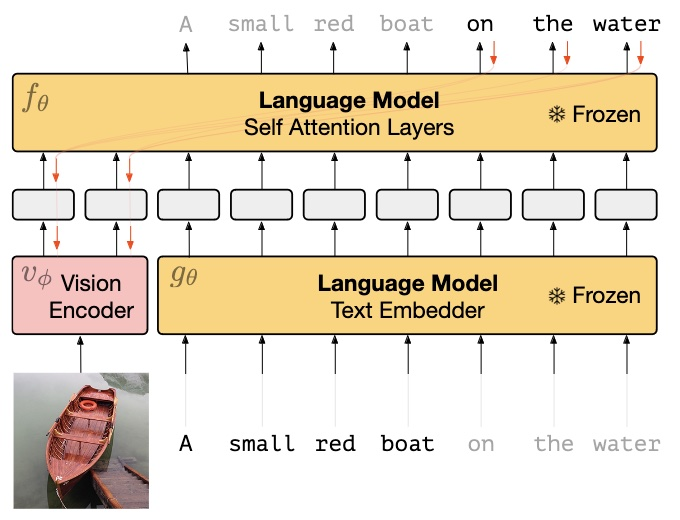

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1c3GMJYtJvn1c5pGVVQ_vAm4YEjjW2Vx7'
output = '/content/test.jpg'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1c3GMJYtJvn1c5pGVVQ_vAm4YEjjW2Vx7
To: /content/test.jpg
100%|██████████| 9.70k/9.70k [00:00<00:00, 7.22MB/s]


'/content/test.jpg'

In [ ]:
import torch
from torchvision.models import resnet50
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the ResNet-50 model
resnet_model = resnet50(pretrained=True)
resnet_model.fc = torch.nn.Identity()  # Remove the final fully connected layer

# Preprocess the image
preprocess = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image = Image.open('/content/test.jpg')
image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Extract features from the image using ResNet-50
with torch.no_grad():
    resnet_model.eval()
    image_features = resnet_model(image_tensor)
texts = 'The image shows a '
def generate_text_from_image_and_text(model, tokenizer, image_embeddings, texts, max_length=30, temperature=0.9):
    sequence_output_size = model.config.hidden_size

    # Prepare the linear adapter for image embeddings
    adapter = torch.nn.Linear(in_features=image_embeddings.shape[1], out_features=sequence_output_size).to(device)
    image_embeddings = image_embeddings.to(device)
    adapter_output = adapter(image_embeddings).to(torch.float16)

    # Tokenize the input text and ensure it's on the correct device
    text_tokens = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

    # Initialize generated text as empty list
    generated_text = []

    with torch.no_grad():
        # Initialize inputs_embeds tensor with adapter_output for the image
        inputs_embeds = adapter_output.unsqueeze(1)  # Add sequence length dimension
        input_ids = torch.cat([torch.tensor([tokenizer.bos_token_id], dtype=torch.long, device=device).unsqueeze(0), text_tokens], dim=1)
        inputs_embeds = torch.cat((inputs_embeds, model.get_input_embeddings()(input_ids[:, 1:])), dim=1)
        # Iterate to generate text
        for _ in range(max_length):
            if generated_text and tokenizer.decode(generated_text[-1]).endswith('.'):
                break

            # Generate next token with the model
            outputs = model(inputs_embeds=inputs_embeds)
            predictions = outputs.logits[:, -1, :] / temperature
            predicted_token = torch.argmax(predictions, dim=-1)

            # Append generated token to generated text
            generated_text.append(predicted_token.item())
            new_token_embedding = model.get_input_embeddings()(predicted_token.unsqueeze(0))
            inputs_embeds = torch.cat((inputs_embeds, new_token_embedding), dim=1)

    # Decode generated tokens into text
    generated_text = tokenizer.decode(generated_text, skip_special_tokens=True)

    return generated_text

predicted_text = generate_text_from_image_and_text(model, tokenizer, image_features, texts)
print(texts + predicted_text)

The image shows a 3D model of a human brain, with various regions labeled.


### **2. Text-to-Image Generation **

Text-to-image models based on the concept of diffusion processes has made a huge impact in this task and here I will explore the capabilities of the StableDiffusion model.

#### **2.1 Installing Dependencies**

In [1]:
!pip install diffusers mediapy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.2 MB/s eta 0:00:00


#### **2.2 Loading and examinig the Stable Diffusion v2.1 Model**

The StableDiffusionv2.1 model is a relatively performant model that uses an auto-encoder coupled with a model that learns the diffusion process on the latent space.

In [2]:
import torch
from diffusers import StableDiffusionPipeline
from transformers import utils

utils.move_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype = dtype)
pipe = pipe.to(device)
print(pipe)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "stabilityai/stable-diffusion-2-1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



#### **2.3 Generating an image**

Next I generate a sample image by passing a prompt through the pipeline. The diffusion model starts from a noisy image and then tries to progressively a) Remove noise and b) Maximize the alignment of the output image with the input text prompt. The denoising process happens in the latent space so the latent representation must be further decoded into an image with an image-only pre-trained variational autoencoder (VAE).

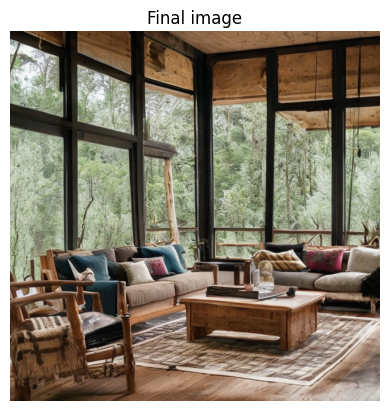

In [ ]:
import torchvision, time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

prompt = "A large living room decorated with rustic furniture merging with the forest"

def callback(pipe, step, timestep, data):
  if step % 5 == 0:
    latents = data['latents']
    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clip(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float()
    clear_output(wait = True)
    plt.figure(); plt.title("Iteration %d" % step);
    plt.imshow(image[0]);plt.axis('off'); plt.show();
  return data

images = pipe(prompt = prompt,
              num_inference_steps = 50,
              generator = torch.Generator(device).manual_seed(123),
              guidance_scale = 7.5,
              callback_on_step_end = callback).images

clear_output(wait = True)
plt.figure(); plt.title("Final image");
plt.imshow(images[0]);plt.axis('off'); plt.show();
images[0].save("owl.jpg")

#### **2.5 AutoEncoding with a Pre-trained Variational AutoEncoder **

Given the following image, use the variational autoencoder (VAE) used by the previously used StableDiffusion model to encode the image and then add random gaussian noise centered at zero with a standard deviation of 2.0 to the latent space of the VAE and then decode back the output. Show input and output side by side.

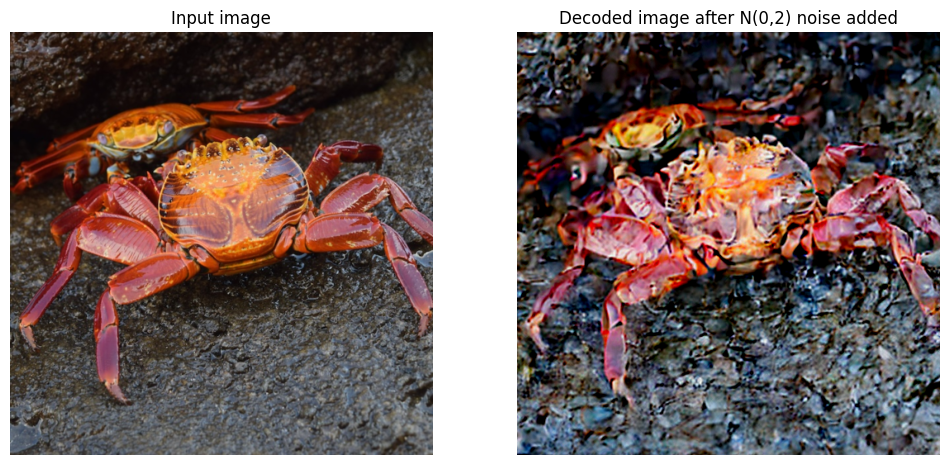

In [ ]:
import io
import requests
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

from diffusers import AutoencoderKL

# download
img_url = 'http://www.cs.rice.edu/~vo9/deep-vislang/crabs-small.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # imagesize
    transforms.ToTensor()  # change to tensor
])

# preprocess
img_tensor = transform(img_pil).unsqueeze(0)

# load the vae
url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"
model = AutoencoderKL.from_single_file(url)

# encode and add noise
with torch.no_grad():
    encoded_output = model.tiled_encode(img_tensor)
    z = encoded_output.latent_dist.sample()
    z_noisy = z + torch.randn_like(z) * 2.0

# decode
with torch.no_grad():
    decoded_output = model.tiled_decode(z_noisy)

# visualize
plt.figure(figsize=(10, 5))

# imput image
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title('Input Image')
plt.axis('off')

decoded_img = transforms.ToPILImage()(decoded_output.sample[0].clamp(0, 1))
plt.subplot(1, 2, 2)
plt.imshow(decoded_img)
plt.title('Decoded Image with Noise')
plt.axis('off')

plt.show()


#### **2.6 Generate an image **

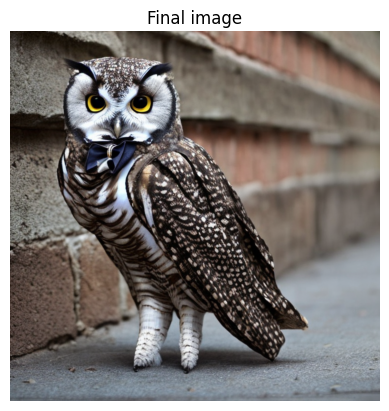

In [13]:
import torch
import torchvision
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

prompt = "An owl wear shoes and bowtie, and stand against a brick wall"

# Callback function to visualize progress
def callback(pipe, step, timestep, data):
    if step % 5 == 0:
        latents = data['latents']
        latents = 1 / 0.18215 * latents
        image = pipe.vae.decode(latents).sample
        image = (image / 2 + 0.5).clip(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).float()
        clear_output(wait=True)
        plt.figure(); plt.title(f"Iteration {step}")
        plt.imshow(image[0]); plt.axis('off'); plt.show()
    return data

# Generate images with the provided prompt and settings
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device).manual_seed(121)

images = pipe(prompt=prompt,
              num_inference_steps=100,
              generator=generator,
              guidance_scale=6.5,
              callback_on_step_end=callback).images

# Display the final image
clear_output(wait=True)
plt.figure(); plt.title("Final image")
plt.imshow(images[0]); plt.axis('off'); plt.show()

# Save the final image
images[0].save("owl_with_bowtie_and_shoes.jpg")